# Using MinBLEP to generate a Saw

In [1]:
pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
from minblep import generate_min_blep

sample_rate = 44100

Picking up from where we left off with the MinBlep notebook:

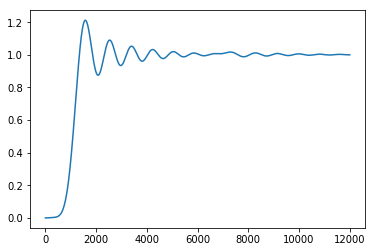

In [3]:
plot(generate_min_blep(15, 400))

In [4]:
def gen_pure_saw(osc_freq, sample_rate, num_samples, initial_phase=0):
    peak_amplitude = 1.0
    two_pi = 2.0 * np.pi
    phase = initial_phase
    for i in range(0, num_samples):
        out_amp = peak_amplitude - (peak_amplitude / np.pi * phase)
        phase = phase + ((2 * np.pi * osc_freq) / sample_rate)
        if phase >= two_pi:
            phase -= two_pi
        yield out_amp

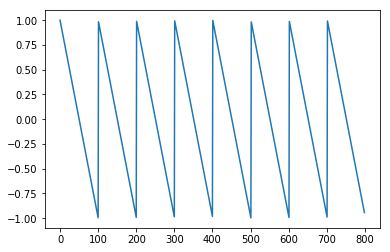

In [5]:
plot(list(gen_pure_saw(440, sample_rate, 800)))

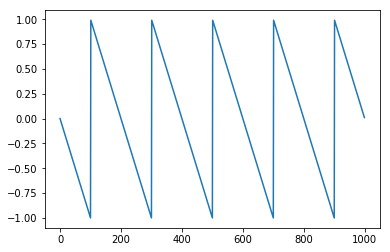

In [6]:
# 5hz, 1000 samples per second, 1000 samples, beginning phase is pi
# this should plot 5 cycles, and begin at 0
plot(list(gen_pure_saw(5, 1000, 1000, np.pi)))

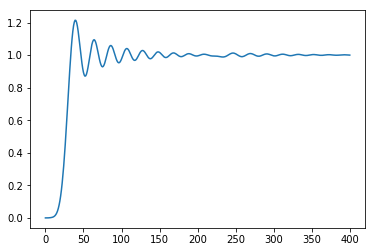

In [7]:
blep_buf = generate_min_blep(20, 10)
plot(blep_buf)

The above saw algorithm goes from -1 to 1, but the blep is from 0 to 1, so it needs to be scaled:

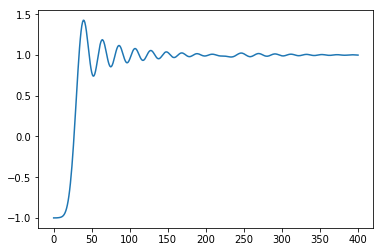

In [8]:
scaled_blep = [val * 2 - 1 for val in blep_buf]
plot(scaled_blep)

In [9]:
def gen_bl_saw(blep_buffer, osc_freq, sample_rate, num_samples, initial_phase=0):
    blep_size = len(blep_buffer)
    blep_pointers = []
    
    peak_amplitude = 1.0
    two_pi = 2.0 * np.pi
    phase = initial_phase
    for i in range(0, num_samples):
        out_amp = peak_amplitude - (peak_amplitude / np.pi * phase)
        
        for ptr in blep_pointers:
            out_amp *= blep_buffer[ptr]
        blep_pointers = [(ptr + 1) for ptr in blep_pointers if ptr + 1 < blep_size]
        
        phase = phase + ((2 * np.pi * osc_freq) / sample_rate)
        if phase >= two_pi:
            phase -= two_pi
            blep_pointers.append(0)

        yield out_amp

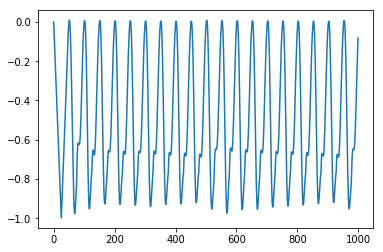

In [10]:
raw_wave = gen_pure_saw(880, sample_rate, 1000, np.pi)
bl_wave = list(gen_bl_saw(scaled_blep, 880, sample_rate, 1000, np.pi))
plot(bl_wave)

In [11]:
def plot_spectrum(signal, sample_rate):
    # http://samcarcagno.altervista.org/blog/basic-sound-processing-python/
    size = len(signal)
    fft_res = np.fft.fft(signal)
    fft_unique_points = int(ceil((size+1)/2.0))
    p = abs(fft_res[0:fft_unique_points])
    p = p / float(size)
    p = p ** 2
    if size % 2 == 1:
        p[1:len(p)] = p[1:len(p)] * 2
    else:
        p[1:len(p) - 1] = p[1:len(p) - 1] * 2
    freq_axis_array = arange(0, fft_unique_points, 1.0) * (sample_rate / size)
    plot(freq_axis_array/1000, 10*log10(p))
    #xscale('log')
    #xlim(xmin=20)
    xlabel('Frequency (kHz)')
    ylabel('Power (dB)')

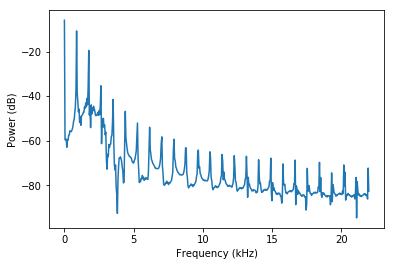

In [12]:
plot_spectrum(bl_wave, sample_rate)

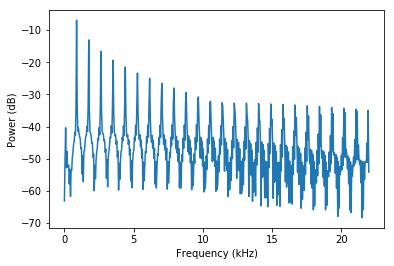

In [13]:
plot_spectrum(list(raw_wave), sample_rate)

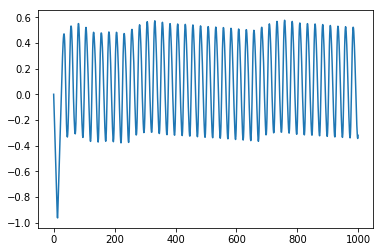

In [14]:
raw_wave = list(gen_pure_saw(1760, sample_rate, 1000, np.pi))
bl_wave = list(gen_bl_saw(scaled_blep, 1760, sample_rate, 1000, np.pi))
plot(bl_wave)

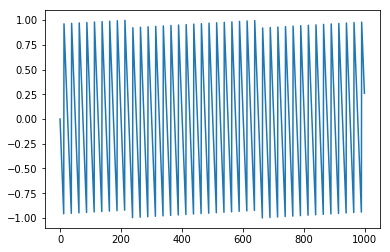

In [15]:
plot(raw_wave)

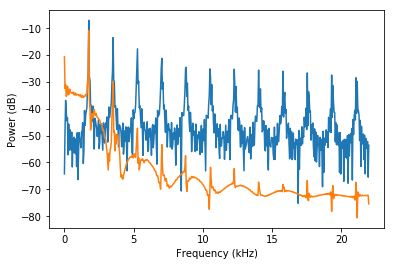

In [16]:
plot_spectrum(raw_wave, sample_rate)
plot_spectrum(bl_wave, sample_rate)

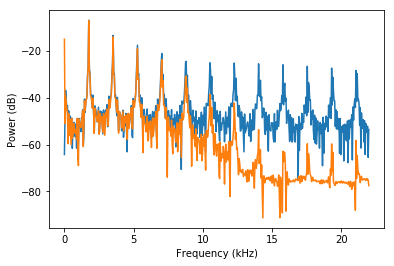

In [17]:
other_blep = [val * 2 - 1 for val in generate_min_blep(10, 2)]
bl_wave = list(gen_bl_saw(other_blep, 1760, sample_rate, 1000, np.pi))
plot_spectrum(list(gen_pure_saw(1760, sample_rate, 1000, np.pi)), sample_rate)
plot_spectrum(bl_wave, sample_rate)

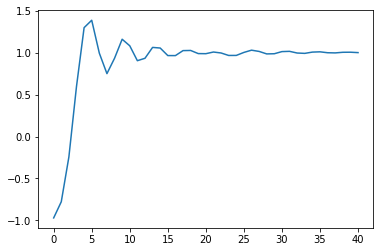

In [18]:
plot(other_blep)

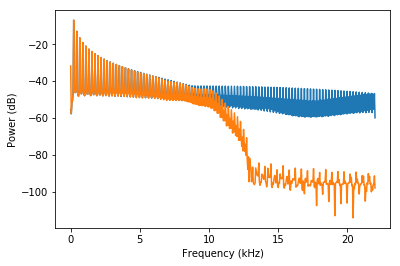

In [19]:
lf_blep = [val * 2 - 1 for val in generate_min_blep(10, 2)]
bl_wave = list(gen_bl_saw(lf_blep, 220, sample_rate, 1000, np.pi))
plot_spectrum(list(gen_pure_saw(220, sample_rate, 1000, np.pi)), sample_rate)
plot_spectrum(bl_wave, sample_rate)

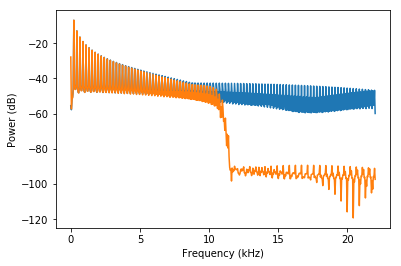

In [20]:
lf_blep = [val * 2 - 1 for val in generate_min_blep(50,2)]
bl_wave = list(gen_bl_saw(lf_blep, 220, sample_rate, 1000, np.pi))
plot_spectrum(list(gen_pure_saw(220, sample_rate, 1000, np.pi)), sample_rate)
plot_spectrum(bl_wave, sample_rate)

An interesting observation here: In this plot, it really looks like this is doing what we want it to do: The whole spectrum above ~11k falls off pretty sharply.  The problem here is that we want that drop-off to happen at nyquist.  The problem here is that the `gen_bl_saw` algorithm isn't properly resampling the blep buffer, and since the buffer is 2x oversampled, the drop-off happens at 1/2 Nyquist.

This also indicates that we should expect some aliasing, but that it will be about 90dB quieter than the fundamental, and about 45dB quieter than Nyquist.

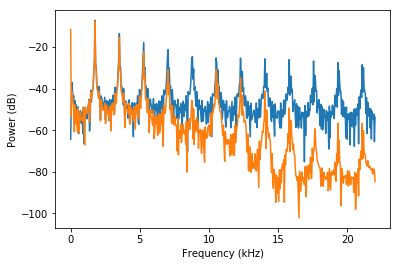

In [28]:
lf_blep = [val * 2 - 1 for val in generate_min_blep(50, 2)]
bl_wave = list(gen_bl_saw(lf_blep, 1760, sample_rate, 1000, np.pi))
plot_spectrum(list(gen_pure_saw(1760, sample_rate, 1000, np.pi)), sample_rate)
plot_spectrum(bl_wave, sample_rate)

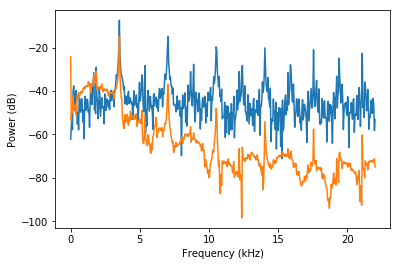

In [29]:
lf_blep = [val * 2 - 1 for val in generate_min_blep(50, 8)]
bl_wave = list(gen_bl_saw(lf_blep, 3520, sample_rate, 1000, np.pi))
plot_spectrum(list(gen_pure_saw(3520, sample_rate, 1000, np.pi)), sample_rate)
plot_spectrum(bl_wave, sample_rate)